<a href="https://colab.research.google.com/github/AstrakhantsevaAA/confidence_estimation_resnet/blob/master/ood_detection_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!git clone https://github.com/AstrakhantsevaAA/confidence_estimation_resnet.git

fatal: destination path 'confidence_estimation_resnet' already exists and is not an empty directory.


In [0]:
import pdb
import argparse
import numpy as np
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable
from confidence_estimation_resnet.model import resnet
import seaborn as sns

In [12]:
modes = ['baseline', 'confidence', 'confidence_scaling']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
np.random.seed(0)
torch.cuda.manual_seed(0)
cudnn.deterministic = True
cudnn.benchmark = False
path = 'confidence_estimation_resnet/checkpoint'
filename = [f'CIFAR_resnet_0.0.pth', f'CIFAR_resnet_0.3.pth']
validation = False

cuda:0


In [13]:
###########################
### Set up data loaders ###
###########################

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)])

# # tinyImageNet_crop and LSUN_crop are 36x36, so crop to 32x32
crop_transform = transforms.Compose([transforms.CenterCrop(size=(32, 32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)])


num_classes = 10
ind_dataset = datasets.CIFAR10(root='data/',
                                   train=False,
                                   transform=transform,
                                   download=True)


# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet
data_path = 'IMagenet/tiny-imagenet-200/val/'
ood_dataset = datasets.ImageFolder(root=data_path, transform=crop_transform)


ind_loader = torch.utils.data.DataLoader(dataset=ind_dataset,
                                         batch_size=100,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)

ood_loader = torch.utils.data.DataLoader(dataset=ood_dataset,
                                         batch_size=100,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=2)
if validation:
    # Limit dataset to first 1000 samples for validation and fine-tuning
    # Based on validation procedure from https://arxiv.org/abs/1706.02690
    ood_loader.dataset.imgs = ood_loader.dataset.imgs[:1000]
    ood_loader.dataset.__len__ = 1000
else:
    ood_loader.dataset.imgs = ood_loader.dataset.imgs[1000:]
    ood_loader.dataset.__len__ = len(ood_loader.dataset.imgs)

Files already downloaded and verified
fatal: destination path 'IMagenet' already exists and is not an empty directory.


In [0]:
##############################################
### Evaluate out-of-distribution detection ###
##############################################

def evaluate(data_loader, mode):
    out = []
    xent = nn.CrossEntropyLoss()
    for data in data_loader:
        if type(data) == list:
            images, labels = data
        else:
            images = data

        images = Variable(images, requires_grad=True).to(device)
        images.retain_grad()

        if mode == 'confidence':
            _, confidence = cnn(images)
            confidence = torch.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'confidence_scaling':
            epsilon = 0.01

            cnn.zero_grad()
            _, confidence = cnn(images)
            confidence = torch.sigmoid(confidence).view(-1)
            loss = torch.mean(-torch.log(confidence))
            loss.backward()

            images = images - epsilon * torch.sign(images.grad)
            images = Variable(images.data, requires_grad=True)

            _, confidence = cnn(images)
            confidence = torch.sigmoid(confidence)
            confidence = confidence.data.cpu().numpy()
            out.append(confidence)

        elif mode == 'baseline':
            # https://arxiv.org/abs/1610.02136
            pred, _ = cnn(images)
            pred = F.softmax(pred, dim=-1)
            pred = torch.max(pred.data, 1)[0]
            pred = pred.cpu().numpy()
            out.append(pred)

    out = np.concatenate(out)
    return out

In [0]:
def tpr95(ind_confidences, ood_confidences):
    #calculate the falsepositive error when tpr is 95%
    Y1 = ood_confidences
    X1 = ind_confidences

    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / 100000

    total = 0.0
    fpr = 0.0
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 >= delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        if tpr <= 0.9505 and tpr >= 0.9495:
            fpr += error2
            total += 1

    fprBase = fpr / total

    return fprBase


def detection(ind_confidences, ood_confidences, n_iter=100000, return_data=False):
    # calculate the minimum detection error
    Y1 = ood_confidences
    X1 = ind_confidences

    start = np.min([np.min(X1), np.min(Y1)])
    end = np.max([np.max(X1), np.max(Y1)])
    gap = (end - start) / n_iter

    best_error = 1.0
    best_delta = None
    all_thresholds = []
    all_errors = []
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(X1 < delta)) / np.float(len(X1))
        error2 = np.sum(np.sum(Y1 > delta)) / np.float(len(Y1))
        detection_error = (tpr + error2) / 2.0

        if return_data:
            all_thresholds.append(delta)
            all_errors.append(detection_error)

        if detection_error < best_error:
            best_error = np.minimum(best_error, detection_error)
            best_delta = delta

    if return_data:
        return best_error, best_delta, all_errors, all_thresholds
    else:
        return best_error, best_delta


weights: resnet_0.0.pth
Method: baseline
TPR95 (lower is better):  0.7701230263157927
Detection error (lower is better):  0.25470000000000004
Best threshold: 0.994980433842611
AUROC (higher is better):  0.7999092750000001
AUPR_IN (higher is better):  0.7989932420490937
AUPR_OUT (higher is better):  0.7663572169250217


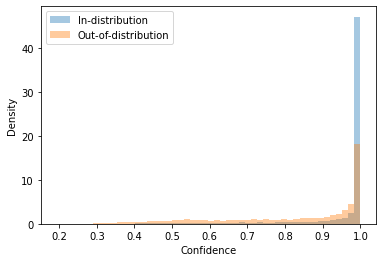


weights: resnet_0.3.pth
Method: baseline
TPR95 (lower is better):  0.7516510588235283
Detection error (lower is better):  0.24395
Best threshold: 0.9935260602658
AUROC (higher is better):  0.8048847699999999
AUPR_IN (higher is better):  0.7921448790943348
AUPR_OUT (higher is better):  0.7795174193861465


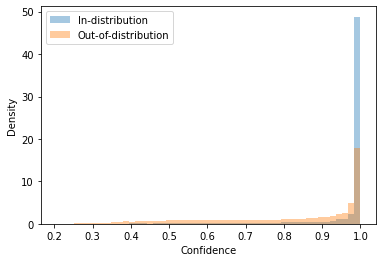


weights: resnet_0.0.pth
Method: confidence
TPR95 (lower is better):  0.995181065088756
Detection error (lower is better):  0.5
Best threshold: 0.39738115668296814
AUROC (higher is better):  0.353228275
AUPR_IN (higher is better):  0.39950725817847876
AUPR_OUT (higher is better):  0.4016509582422866


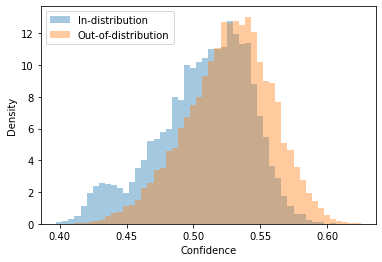


weights: resnet_0.3.pth
Method: confidence
TPR95 (lower is better):  0.8284966101694916
Detection error (lower is better):  0.24245
Best threshold: 0.8189505278371763
AUROC (higher is better):  0.802763855
AUPR_IN (higher is better):  0.8081118160417672
AUPR_OUT (higher is better):  0.7518159881668218


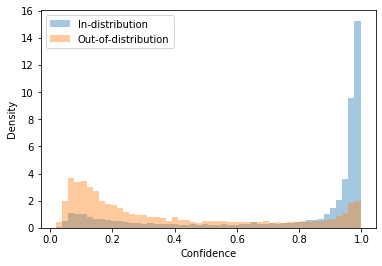


weights: resnet_0.0.pth
Method: confidence_scaling
TPR95 (lower is better):  0.995563925729442
Detection error (lower is better):  0.5
Best threshold: 0.4038386642932892
AUROC (higher is better):  0.33322856
AUPR_IN (higher is better):  0.39071937782781985
AUPR_OUT (higher is better):  0.39229771982834594


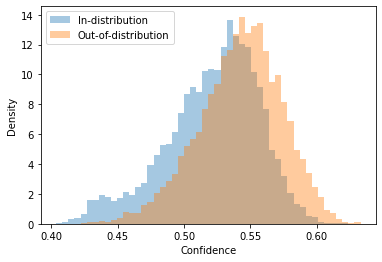


weights: resnet_0.3.pth
Method: confidence_scaling
TPR95 (lower is better):  0.6736535558780871
Detection error (lower is better):  0.2319
Best threshold: 0.9267890741267286
AUROC (higher is better):  0.82047815
AUPR_IN (higher is better):  0.8008667685712745
AUPR_OUT (higher is better):  0.8018580485839428


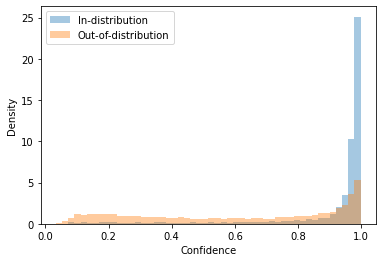

In [16]:
##############################
### Load pre-trained model ###
##############################
for mode in modes:
    for fn in filename:
        cnn = resnet.resnet18(num_classes=num_classes)

        pretrained_dict = torch.load(fn, map_location=torch.device('cpu'))
        cnn.load_state_dict(pretrained_dict)
        cnn = cnn.to(device)
        if device == 'cuda':
            cnn = torch.nn.DataParallel(cnn)

        cnn.eval()

        ind_scores = evaluate(ind_loader, mode)
        ind_labels = np.ones(ind_scores.shape[0])

        ood_scores = evaluate(ood_loader, mode)
        ood_labels = np.zeros(ood_scores.shape[0])

        labels = np.concatenate([ind_labels, ood_labels])
        scores = np.concatenate([ind_scores, ood_scores])

        fpr_at_95_tpr = tpr95(ind_scores, ood_scores)
        detection_error, best_delta = detection(ind_scores, ood_scores)
        auroc = metrics.roc_auc_score(labels, scores)
        aupr_in = metrics.average_precision_score(labels, scores)
        aupr_out = metrics.average_precision_score(-1 * labels + 1, 1 - scores)
        state = {
            'weights' : fn[-14:],
            "Method" : mode,
            "TPR95": fpr_at_95_tpr,
            "Detection_error": detection_error,
            "Best_threshold": best_delta,
            "AUROC": auroc,
            "AUPR_IN": aupr_in,
            "AUPR_OUT": aupr_out,
        }
        if not os.path.isdir('metrics'):
            os.mkdir('metrics')
        torch.save(state, f'./metrics/{fn[-14:]}_metrics_{mode}.pth')

        print("")
        print('weights: ' + fn[-14:])
        print("Method: " + mode)
        print("TPR95 (lower is better): ", fpr_at_95_tpr)
        print("Detection error (lower is better): ", detection_error)
        print("Best threshold:", best_delta)
        print("AUROC (higher is better): ", auroc)
        print("AUPR_IN (higher is better): ", aupr_in)
        print("AUPR_OUT (higher is better): ", aupr_out)
        
        ranges = (np.min(scores), np.max(scores))
        plt.figure()
        sns.distplot(ind_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='In-distribution')
        sns.distplot(ood_scores.ravel(), hist_kws={'range': ranges}, kde=False, bins=50, norm_hist=True, label='Out-of-distribution')
        plt.xlabel('Confidence')
        plt.ylabel('Density')
        plt.legend()
        if not os.path.isdir('plots'):
            os.mkdir('plots')
        plt.savefig(f'plots/{fn[-14:]}_confidence_hist_{mode}.png')
        plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


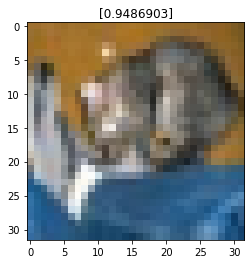

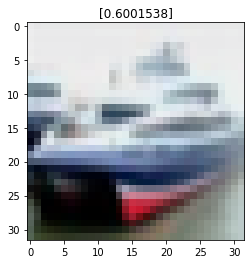

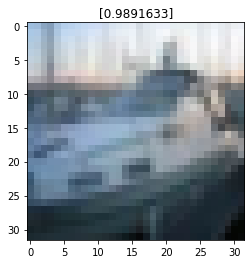

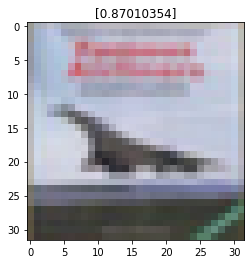

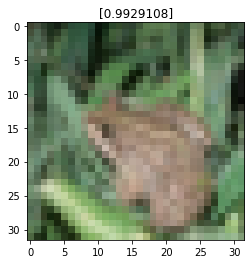

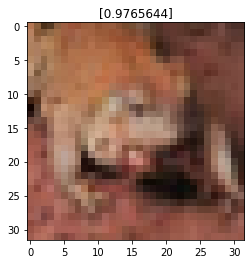

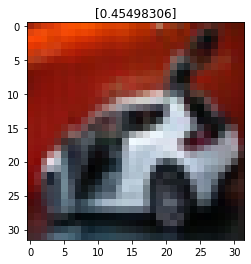

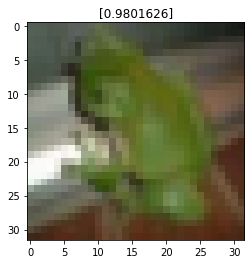

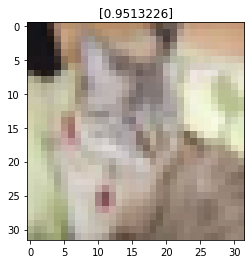

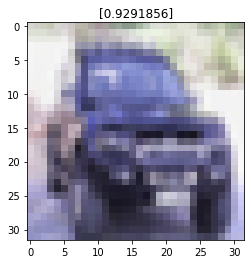

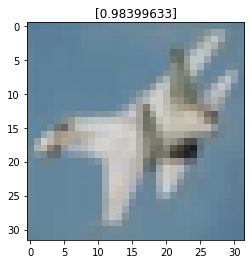

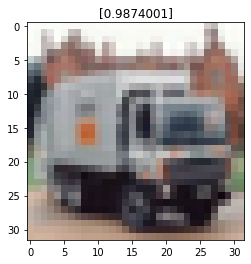

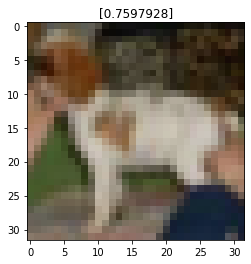

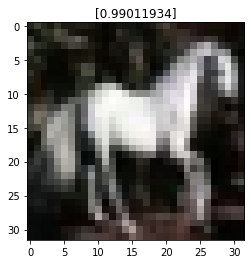

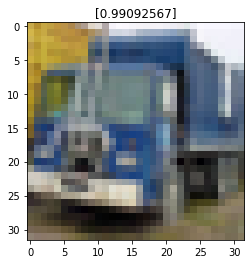

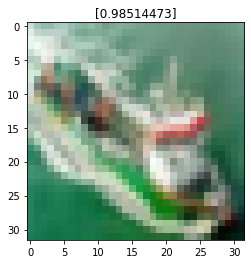

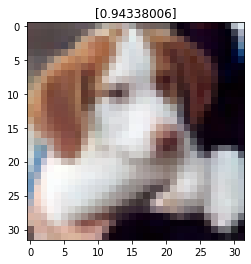

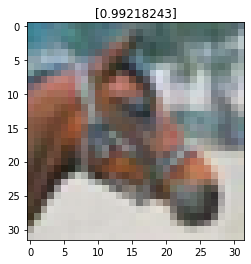

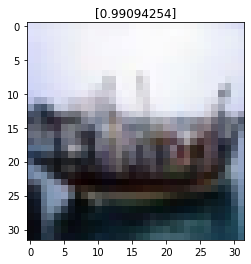

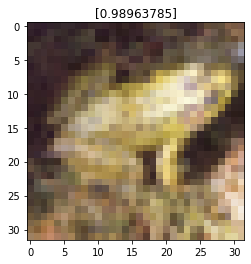

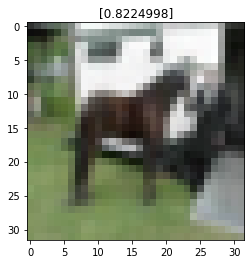

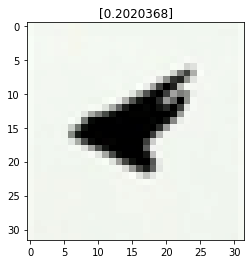

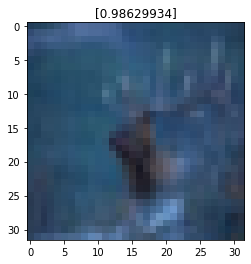

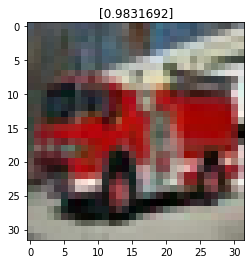

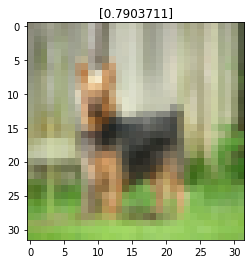

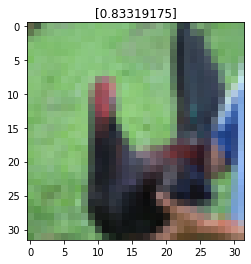

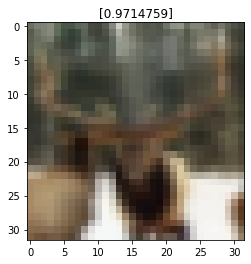

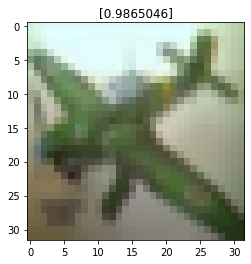

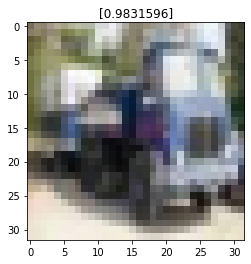

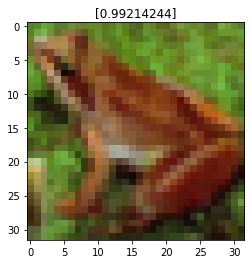

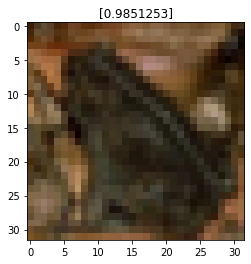

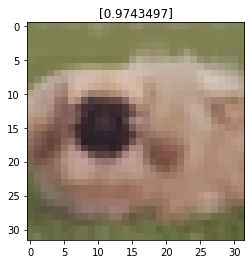

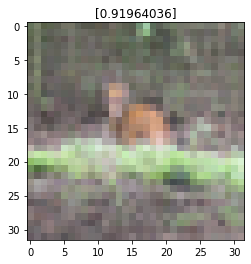

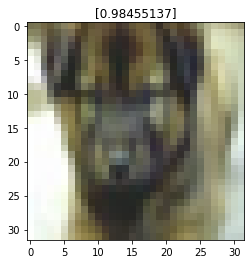

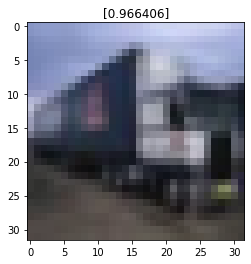

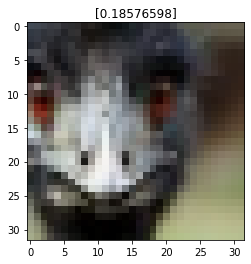

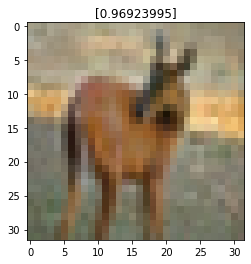

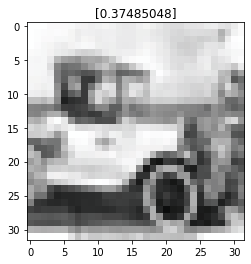

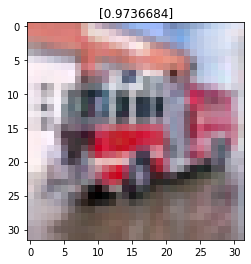

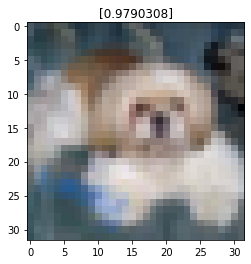

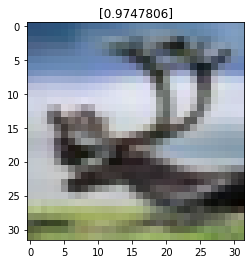

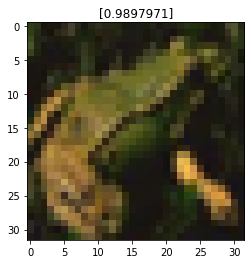

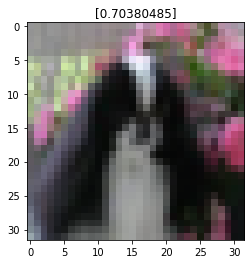

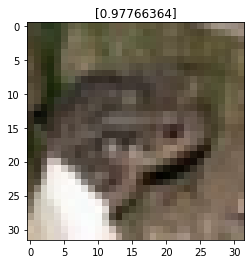

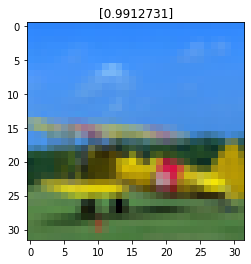

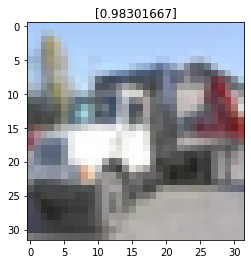

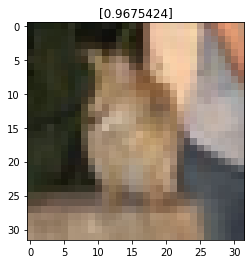

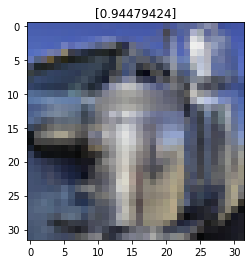

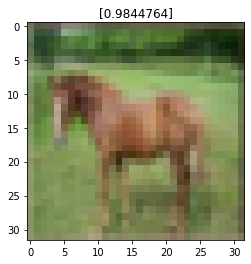

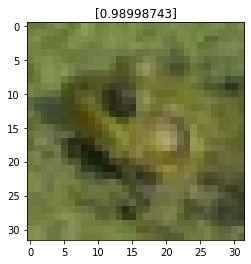

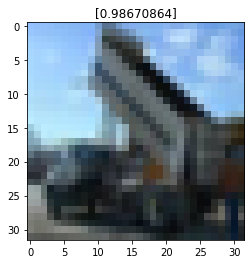

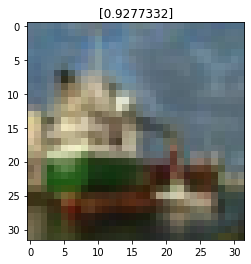

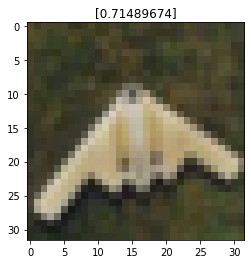

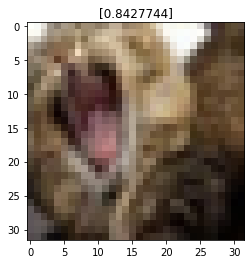

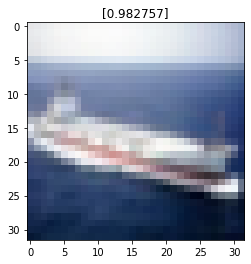

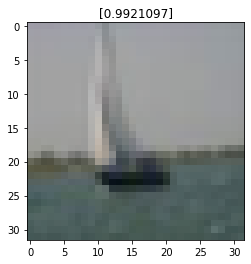

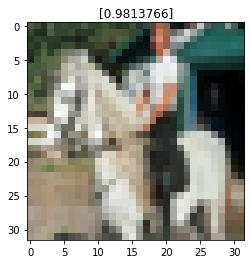

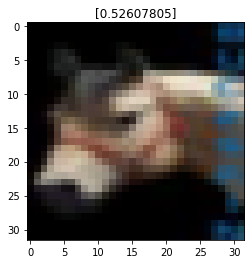

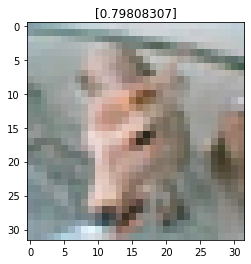

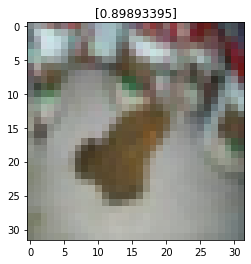

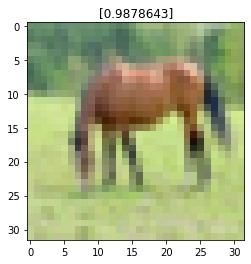

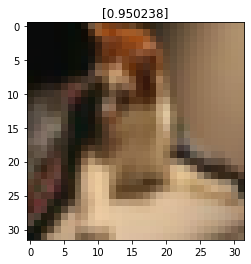

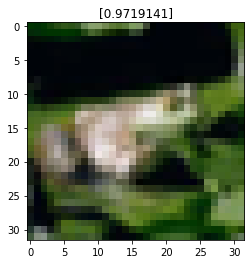

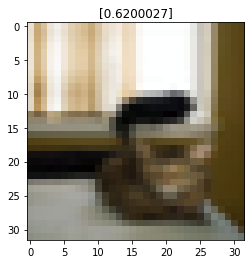

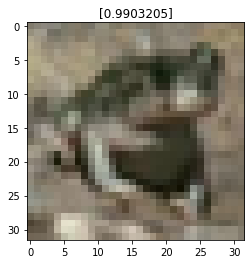

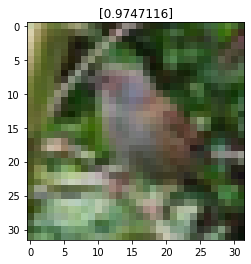

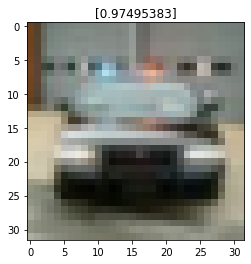

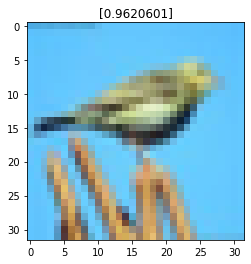

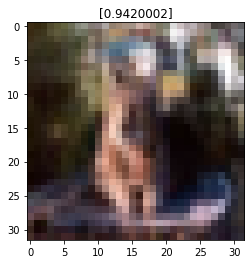

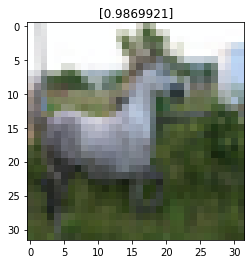

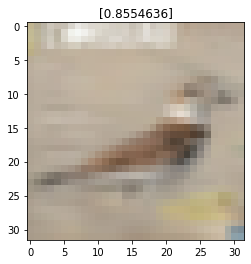

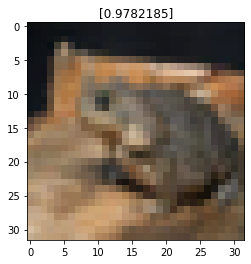

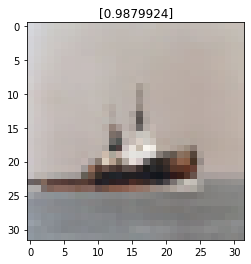

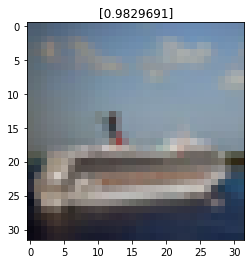

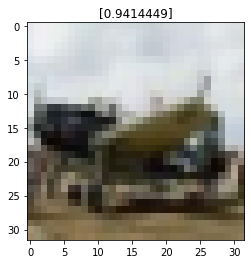

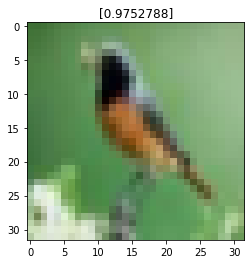

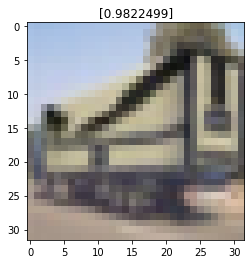

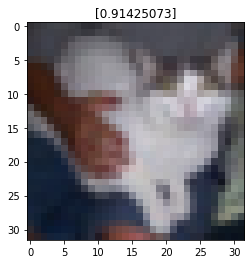

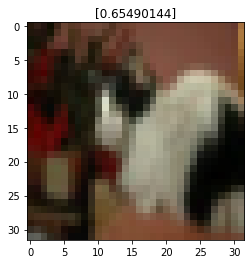

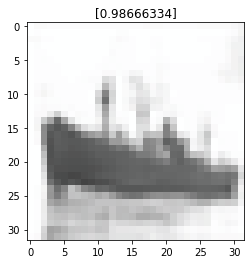

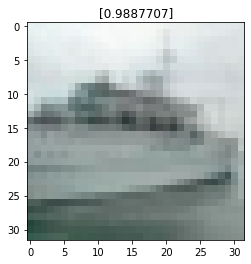

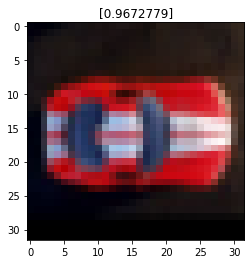

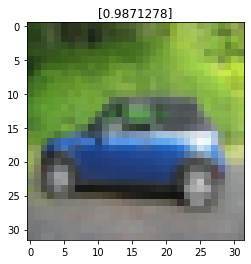

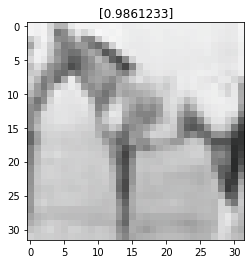

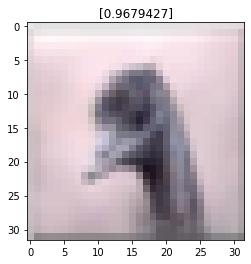

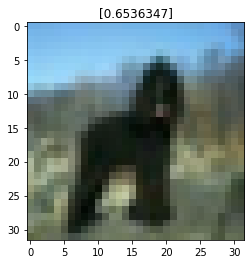

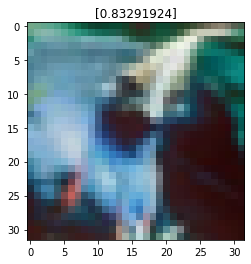

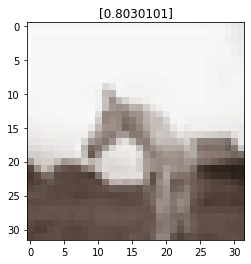

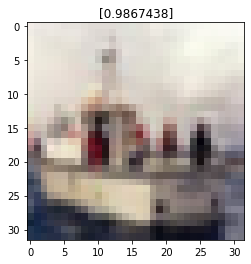

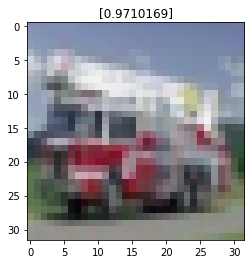

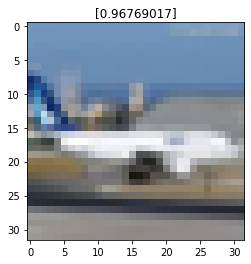

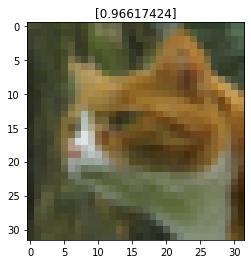

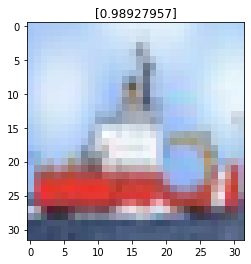

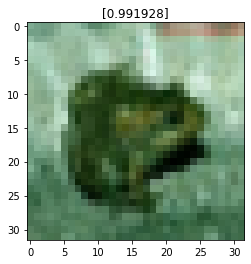

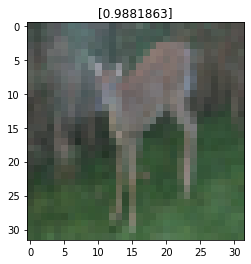

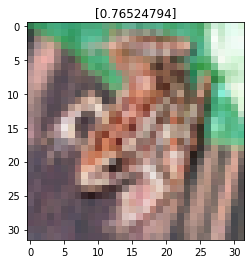

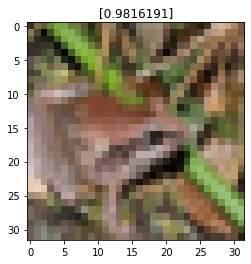

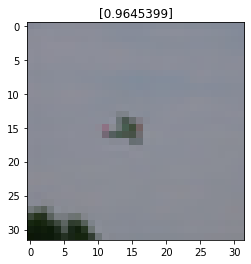

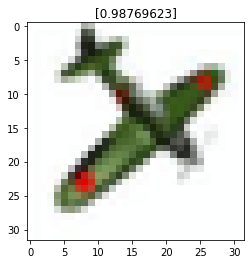

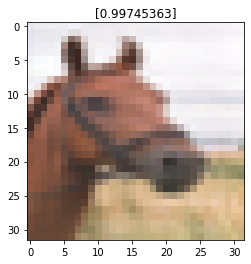

In [17]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()

inputs, labels = next(iter(ind_loader))

for img, pred in zip(inputs, ind_scores):
    show_input(img, title=pred)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


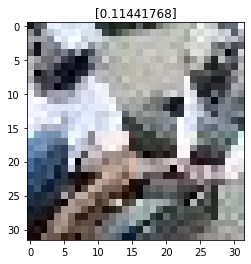

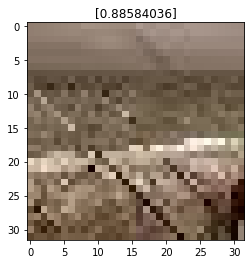

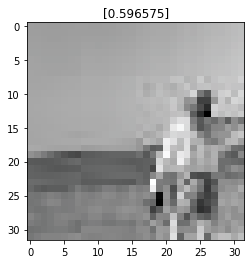

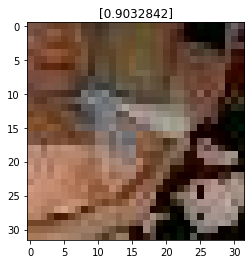

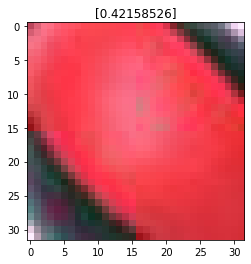

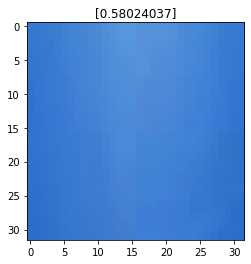

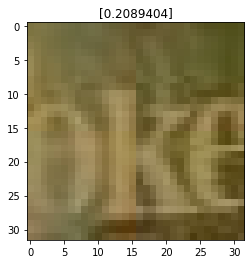

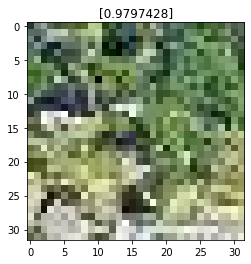

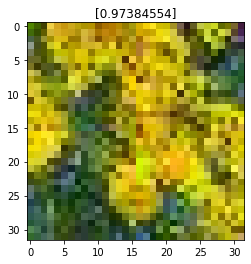

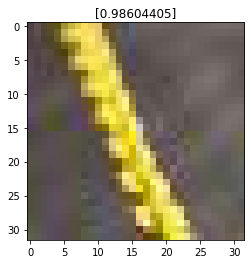

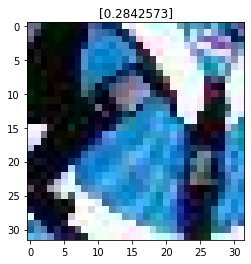

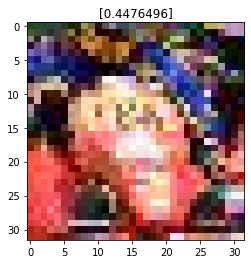

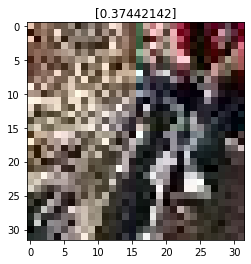

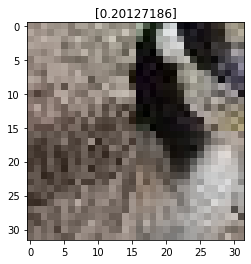

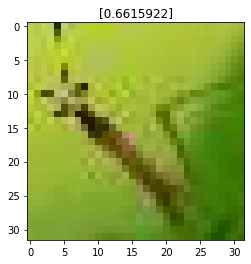

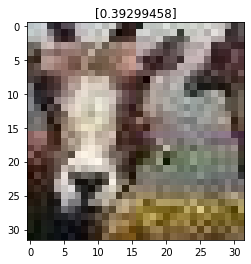

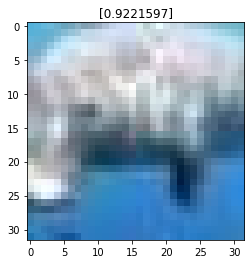

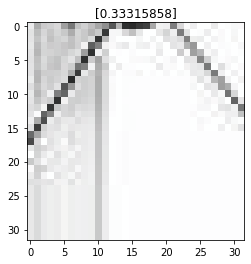

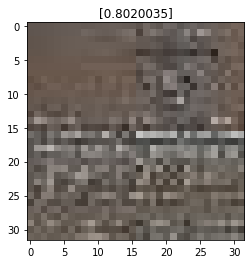

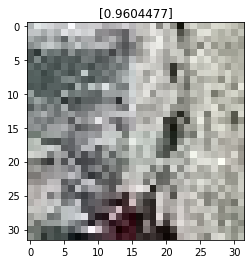

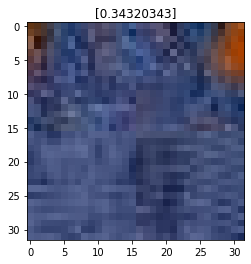

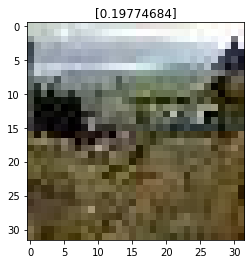

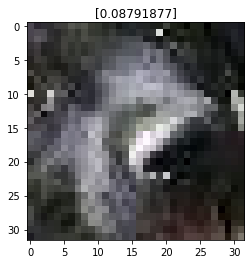

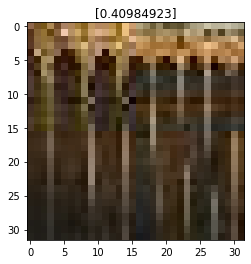

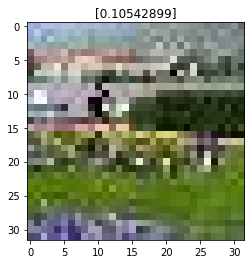

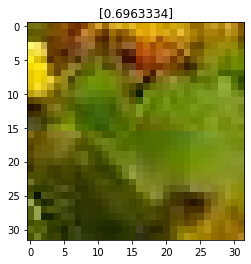

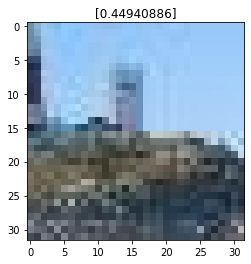

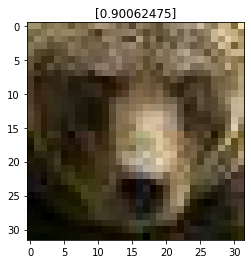

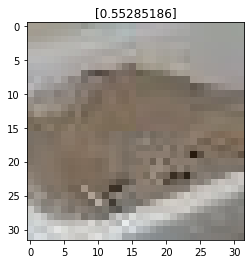

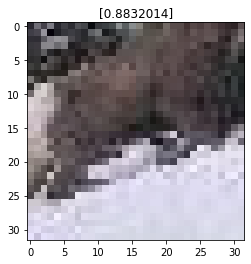

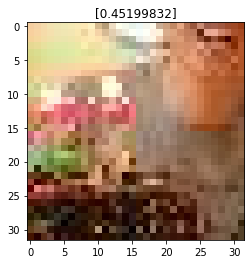

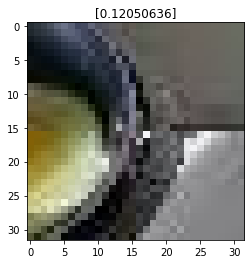

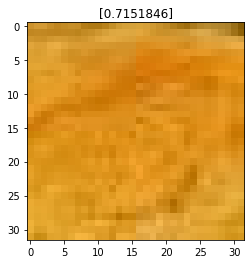

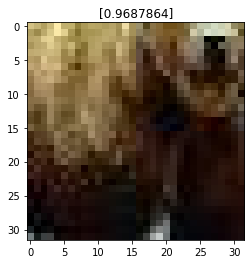

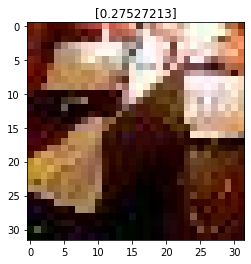

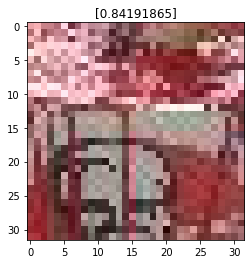

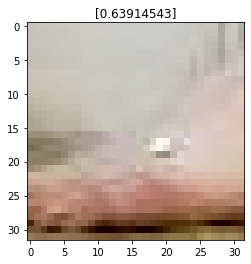

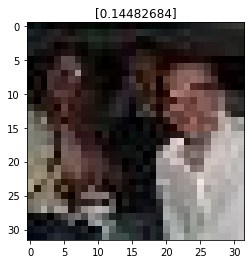

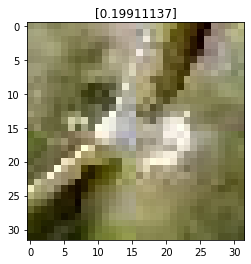

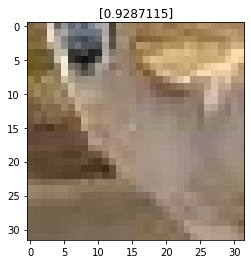

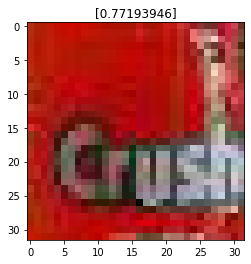

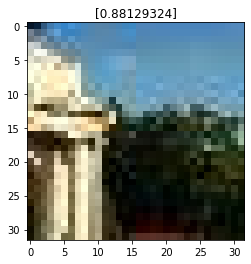

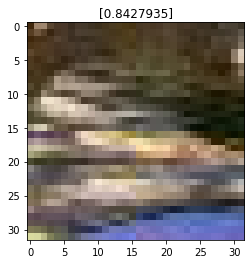

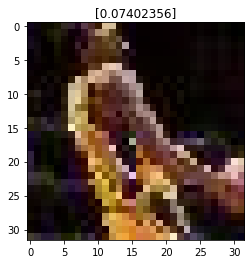

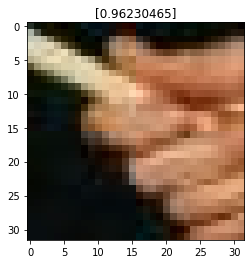

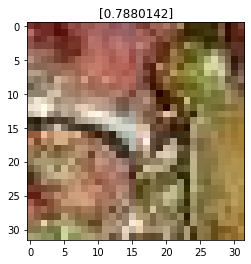

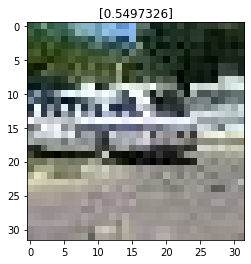

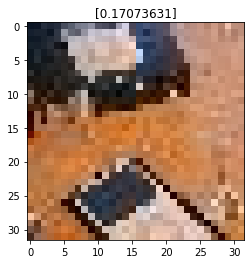

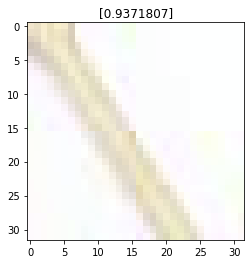

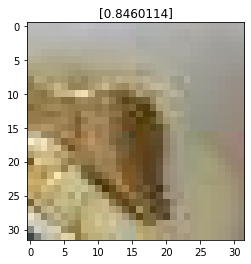

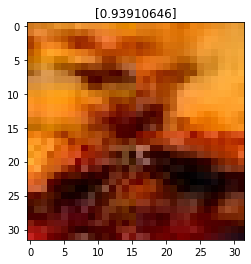

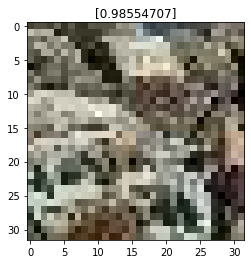

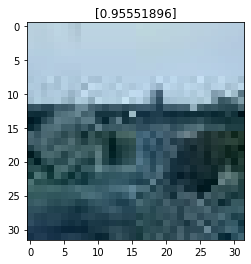

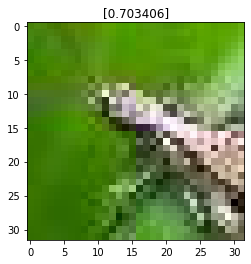

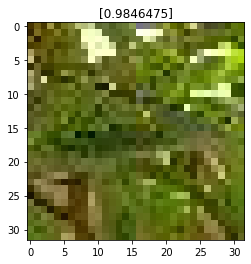

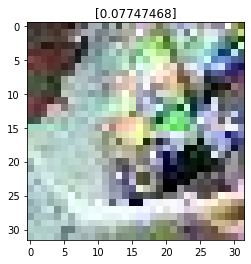

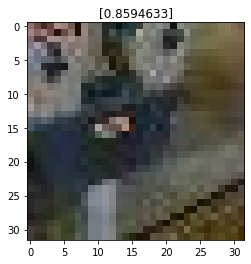

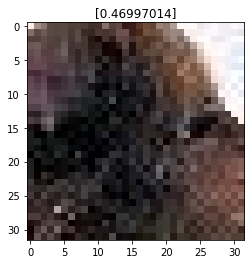

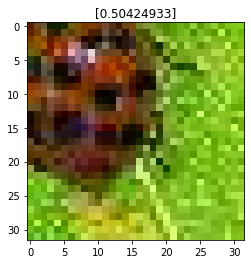

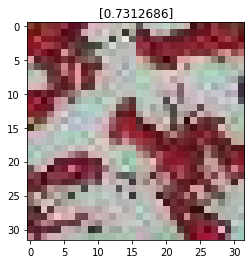

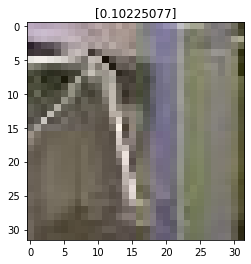

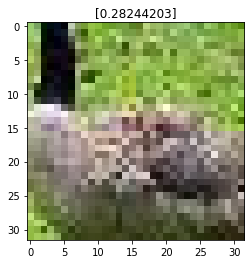

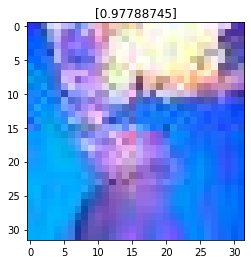

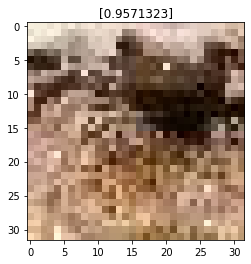

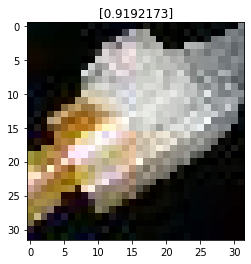

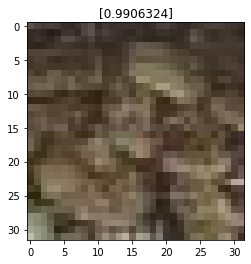

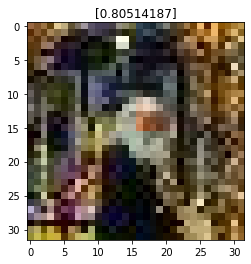

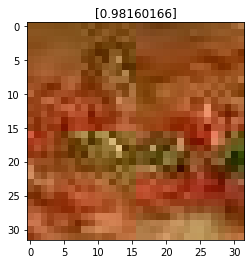

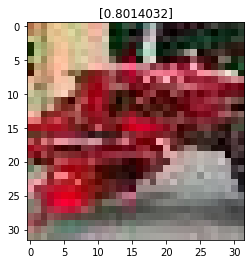

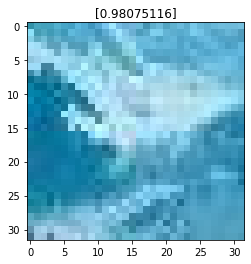

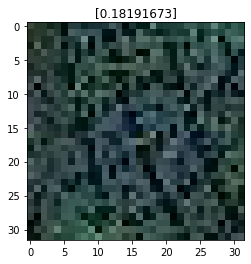

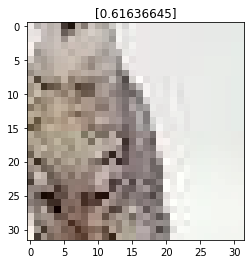

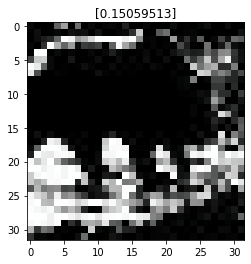

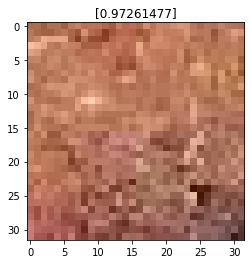

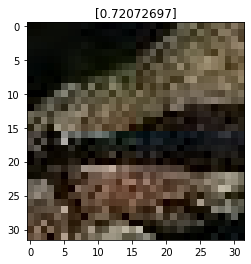

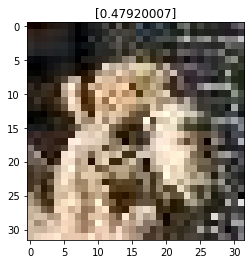

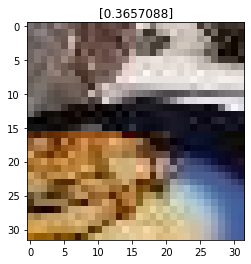

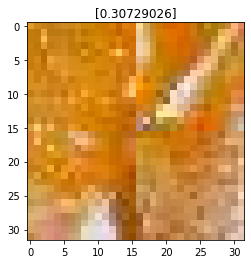

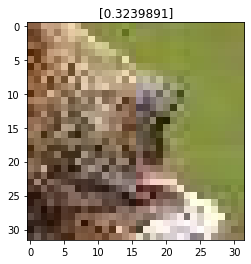

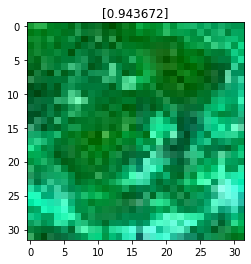

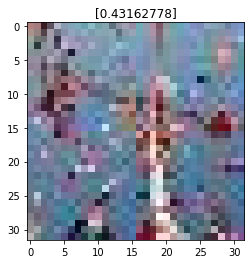

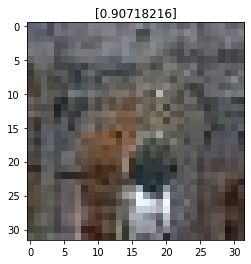

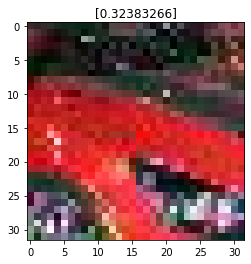

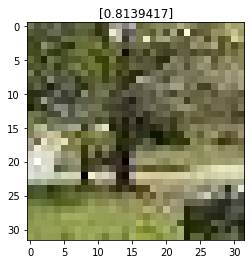

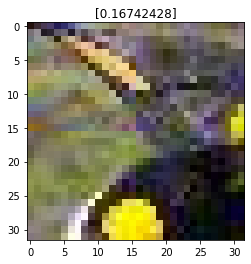

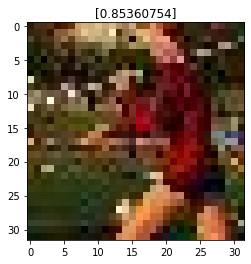

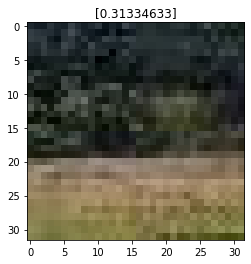

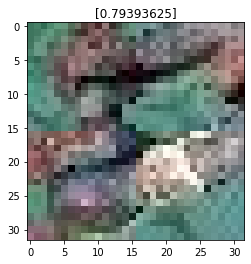

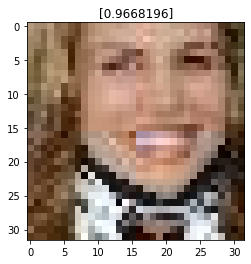

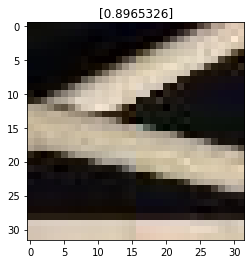

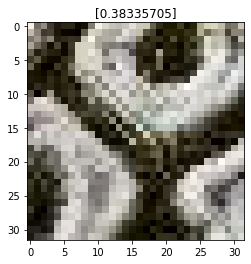

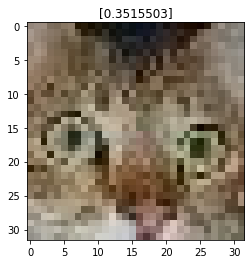

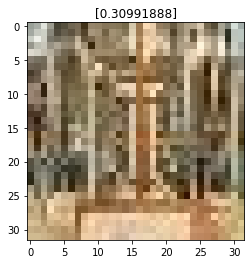

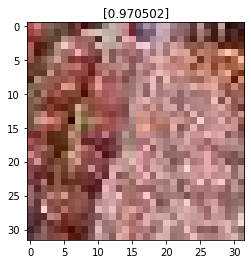

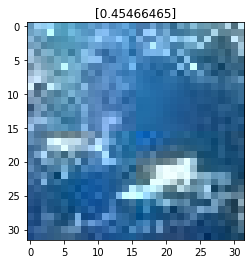

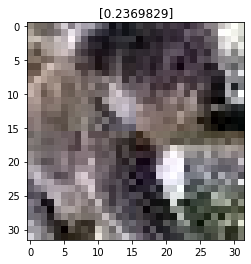

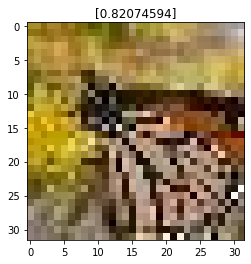

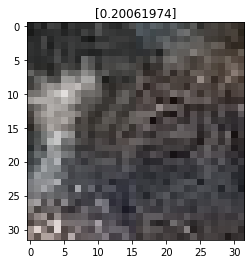

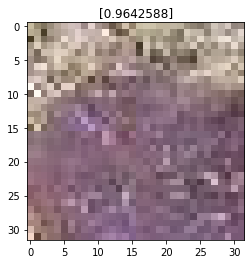

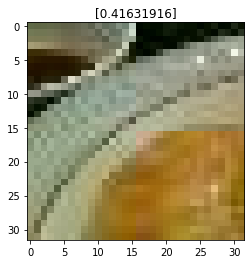

In [18]:
inputs, labels = next(iter(ood_loader))

for img, pred in zip(inputs, ood_scores):
    show_input(img, title=pred)